<a href="https://colab.research.google.com/github/croco22/CapstoneProjectTDS/blob/main/notebooks/03_Dataset_Continuous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extra Task 1: Continuous Dataset Evaluation
In this step, several questions will be answered at once in order to increase the complexity for the model. By introducing multiple questions in a single request, we aim to test how well the model handles and responds to more complex inputs, simulating a real-world scenario where users may provide multiple queries in one interaction.

The secrets `GOOGLE_API_KEY` and `HF_TOKEN` must be configured in your Colab environment for proper execution.

## Imports and Setup

In [1]:
%%capture
!pip install dateparser
!pip install fuzzywuzzy
!pip install word2number

import random
import re
import time

import dateparser
import google.generativeai as genai
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from fuzzywuzzy import fuzz
from google.colab import userdata
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    jaccard_score,
    precision_score,
    recall_score,
)
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
from word2number import w2n

In [2]:
# API setup
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))
model = genai.GenerativeModel('gemini-2.0-flash-exp')
userdata.get('HF_TOKEN')


def generate_text(prompt):
    """
    Generates text based on the provided prompt using the genai model. The function sends the prompt
    to the model, with a generation configuration that includes a temperature of 2.0 for creative output.
    It then waits for 5 seconds to avoid exceeding API limits before returning the generated text.
    """
    try:
        response = model.generate_content(
            prompt,
            generation_config=genai.GenerationConfig(
                temperature=2.0, # creative output
            )
        )
        time.sleep(10) # avoid exceeding API limits
        return response.text.strip()
    except Exception as e:
        exit("Error during API call: ", e)

In [3]:
url = 'https://raw.githubusercontent.com/croco22/CapstoneProjectTDS/refs/heads/main/qa_dataset.json'
data = pd.read_json(url)

data.head()

,type,question,options,intended_answer,context,timestamp
0,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"Absolutely, you've got my consent for that dat...",2025-01-29 13:37:12.404
1,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"Yes, you can absolutely process my data, that'...",2025-01-29 13:37:12.404
2,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"Without any hesitation, I can confirm yes, tha...",2025-01-29 13:37:12.404
3,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"Okay then, for that question regarding data pr...",2025-01-29 13:37:12.404
4,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"That sounds perfectly fine to me, I wholeheart...",2025-01-29 13:37:12.404


## Continuous Text Generation
To generate a coherent text, three questions are grouped together. Since combining multiple questions with phone numbers or dates wouldn't make much sense (because the scenario would be very unrealistic) a random pre-selection is made, where only one number and one date entry are included. Additionally, three random single- and multi-select questions are added. From this set of eight questions, three are randomly selected and then combined into a text.

Previously, we tested a **text summarization model from Hugging Face** for this task. However, the performance was quite poor. When the output length was too long, it did not summarize the content but rather just appended the text. On the other hand, when the output length was too short, important elements of the response were omitted.

In [4]:
prompt = """
    Summarize the following text that answers different questions, which may
    not necessarily be related to the same context. The summary should provide
    a concise version of the text, ensuring that key details and answer
    components are preserved without simply appending or omitting important
    information. Return only the summarized answer text, without quotation marks.
    Text:
"""

In [5]:
def generate_sample_df(data, n=10, advanced=False):
    new_rows = []

    for _ in range(n):
        single_rows = data[data['type'] == 'SINGLE_SELECT'].sample(n=3)
        multi_rows = data[data['type'] == 'MULTI_SELECT'].sample(n=3)
        num_row = data[data['type'] == 'NUMBER'].sample(n=1)
        date_row = data[data['type'] == 'DATE'].sample(n=1)
        preselect = pd.concat([single_rows, multi_rows, num_row, date_row], ignore_index=True)

        random_rows = preselect.sample(n=3)
        combined_text = " ".join(random_rows['context'])
        if advanced:
            combined_text = generate_text(prompt + combined_text)
        random_rows['context'] = combined_text
        new_rows.append(random_rows)

    new_df = pd.concat(new_rows, ignore_index=True)
    return new_df

In [6]:
df_simple = generate_sample_df(data, n=50)
df = generate_sample_df(data, advanced=True)

df.head()

,type,question,options,intended_answer,context,timestamp
0,MULTI_SELECT,Which of the following best describes your pri...,"[Increase productivity, Track project progress...","[Collaborate with team members, Access resourc...","Today's tasks involve team collaboration, acce...",2025-01-13 19:38:16.404
1,DATE,What's the projected completion date for this ...,None,tomorrow,"Today's tasks involve team collaboration, acce...",2025-01-28 06:09:27.404
2,NUMBER,What phone number can we use for contact?,None,+33-175-747-3779,"Today's tasks involve team collaboration, acce...",2025-01-24 16:27:58.404
3,MULTI_SELECT,What is the type of contact?,"[Existing customer, Supplier, New customer / P...","[Existing customer, Supplier, New customer / P...",Existing customers have used us before. Suppli...,2025-01-11 05:30:35.404
4,SINGLE_SELECT,In which phase of the project lifecycle do you...,"[Planning, Execution, Monitoring & Controlling...",Closure,Existing customers have used us before. Suppli...,2025-01-19 14:19:30.404


In [7]:
print("Simple texts:")
for text in df_simple['context'][::3][:5]:
    print(text)

print("\nAdvanced texts:")
for text in df['context'][::3][:5]:
    print(text)

Simple texts:
Right now I’m trying to get organized with a project and I am super keen on getting the JS EcoLine because I’ve seen how awesome it looks, and then to go along with that for the inside projects, the AX100 is perfect for it! Let me think… yup, I can say for certain the best way to describe my use would be Data Analysis, because that is where all the action seems to be lately for me. Well, if I'm being completely honest, thinking about the last quarter, I'd say that while we’ve seen some real positives overall, I do think the area that needs the most attention right now would be Customer Onboarding; we seem to be losing some folks at the very start, which is never good. That said, alongside that, and not necessarily the most needy, there's always room to dial in our Marketing Efficiency to better get to our core market
Let's see, when do I think the project deliverables will be ready? If everything goes according to plan, they should definitely be done by the end of this mo

## Clustering (no longer in use)
This section explores clustering techniques to group similar contexts or responses based on their characteristics. By applying clustering methods, patterns and structures within the dataset can be identified, improving organization and analysis.

The idea was to first cluster the texts during evaluation to make complex tasks, such as identifying notes that are not clearly assignable, more manageable. However, we ultimately decided to evaluate answer texts that address multiple questions separately for each question they contain. This approach led to significantly better results, so we abandoned the clustering method.

In [8]:
transformer_model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
for text in df['context']:
    # Split the text into sentences and remove unnecessary spaces and quotes
    sentences = [sentence.strip(' "') for sentence in re.split(r'[.!?]', text) if sentence]

    # Ensure there are at least two sentences for clustering
    if len(sentences) < 2:
        print("Skipping text: Not enough sentences for clustering.")
        continue

    # Generate sentence embeddings using the transformer model
    sentence_embeddings = transformer_model.encode(sentences)
    similarity_matrix = cosine_similarity(sentence_embeddings)

    # Dynamically determine the number of clusters: minimum of 2 or the number of sentences
    n_clusters = min(len(sentences), 3)

    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')

    try:
        # Perform clustering
        labels = clustering.fit_predict(sentence_embeddings)
    except ValueError as e:
        print(f"Error during clustering: {e}")
        continue

    # Organize sentences into clusters
    clusters = {}
    for sentence, label in zip(sentences, labels):
        clusters.setdefault(label, []).append(sentence)

    # Print the clusters
    for i, (_, grouped_sentences) in enumerate(clusters.items()):
        print(f"Cluster {i}:")
        for sentence in grouped_sentences:
            print(f"* {sentence}")
    print()

Cluster 0:
* Today's tasks involve team collaboration, accessing resources and documentation from a large collection, including specialized folders, completing a specific work task, general app maintenance, and research
Cluster 1:
* The goal is to wrap up by the end of tomorrow
Cluster 2:
* For contact, use the phone number +33-175-747-3779

Cluster 0:
* Today's tasks involve team collaboration, accessing resources and documentation from a large collection, including specialized folders, completing a specific work task, general app maintenance, and research
Cluster 1:
* The goal is to wrap up by the end of tomorrow
Cluster 2:
* For contact, use the phone number +33-175-747-3779

Cluster 0:
* Today's tasks involve team collaboration, accessing resources and documentation from a large collection, including specialized folders, completing a specific work task, general app maintenance, and research
Cluster 1:
* The goal is to wrap up by the end of tomorrow
Cluster 2:
* For contact, use the

## Evaluation
Similar to the evaluation in the notebook '02_Dataset_Evaluation.ipynb' for Task 2.

### Auxiliary Functions

In [10]:
def convert_numbers_in_text(text):
    # Regular expression to find number words contained in questionnaires
    pattern = r'(two thousand|two hundred one|two hundred|fifty-one|thirty-one|twenty-one|sixteen|fifteen|eleven|thirty|twenty|fifty|forty|sixty|ten|five|six|one)'
    # Interesting finding: Regex only works if longer words are in order before shorter that contain similar parts, e.g. fifty-one has to be in front of fifty to work as intended

    def convert(match):
        word = match.group(0)
        try:
            # Convert the word to number
            return str(w2n.word_to_num(word))
        except ValueError:
            return word

    # Replace all number words in the text with their integer equivalents
    converted_text = re.sub(pattern, convert, text, flags=re.IGNORECASE)

    # Now convert ranges like 'twenty to thirty' into '20-30'
    converted_text = re.sub(r'(\d+)\s*(to|and)\s*(\d+)', r'\1-\3', converted_text)

    # Replace text
    # Todo: Dafür noch ne bessere Lösung finden, das ist eig nur n Beispiel und geht auch bei ähnlichen Sätzen nicht
    converted_text = converted_text.replace('more than 2000', 'larger than 2000')
    converted_text = converted_text.replace('More than 2000', 'Larger than 2000')

    return converted_text


def calculate_metrics(y_true, y_pred):
    if not y_true:  # ensure y_true is not empty to avoid errors
        return {"Accuracy": 0, "Precision": 0, "Recall": 0, "F1 Score": 0, "Jaccard Score": 0}
    else:
        return {
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, zero_division=0),
            "Recall": recall_score(y_true, y_pred, zero_division=0),
            "F1 Score": f1_score(y_true, y_pred, zero_division=0),
            "Jaccard Score": jaccard_score(y_true, y_pred, zero_division=0),
        }


def plot_metrics(metrics_per_type, overall_metrics):
    metric_names = ["Accuracy", "Precision", "Recall", "F1 Score", "Jaccard Score"]
    plt.figure(figsize=(8, 5))
    df_heatmap = pd.DataFrame(metrics_per_type).T
    sns.heatmap(df_heatmap, annot=True, cmap="coolwarm", linewidths=0.5, vmin=0, vmax=1)
    plt.title("Metrics per question type")
    plt.show()

In [11]:
def predict_answers(df, qa_pipeline):
    metrics_per_type = dict()

    type_metrics = {t: {"y_true": [], "y_pred": []} for t in ["SINGLE_SELECT", "MULTI_SELECT", "DATE", "NUMBER"]}

    for _, row in df.iterrows():
        predictions = list()
        is_correct = False

        if (row['type'] == "SINGLE_SELECT") or (row['type'] == "MULTI_SELECT"):
            if row['options']:
                converted_context = convert_numbers_in_text(row['context'])
            # Extract answers from context (topk > 1)
            results = qa_pipeline_ms(question=row['question'], context=converted_context)

            if isinstance(results, dict):
                # Convert to list if a single object is found
                results = [results]
            elif not isinstance(results, list):
                print(f"Warning: Unexpected output format from qa_pipeline for question: {row['question']}") # Bei Single Select nicht auch nur string möglich?
                continue

            # Check answer for similarity with given answer options
            for result in results:
                extracted_answer = result.get('answer', '')
                for option in row['options']:
                    similarity_score = fuzz.ratio(extracted_answer.lower(), option.lower())
                    if similarity_score >= 60:  # Threshold for similarity
                        predictions.append((option, result.get('score', 0)))

        if row['type'] == "SINGLE_SELECT":
            # Select prediction with highest confidence
            if predictions:
                predicted_option, confidence = max(predictions, key=lambda x: x[1])
                is_correct = predicted_option == row['intended_answer']
            else:
                print(f"No predictions found for SINGLE_SELECT: {row['question']}")
                predicted_option = None

        if row['type'] == "MULTI_SELECT":
            if predictions:
                # Select all answers that matched an option
                predicted_option = []
                for option, score in predictions:
                    if option not in predicted_option:
                        predicted_option.append(option)
                is_correct = set(predicted_option) == set(row['intended_answer'])
            else:
                print(f"No predictions found for MULTI_SELECT: {row['question']}")
                predicted_option = None

        if row['type'] == "DATE":
            try:
                # Base timestamp from dataframe column (Unix-Timestamp)
                base_timestamp = pd.Timestamp(row['timestamp'], unit='ms')

                # Extract time expression and convert it to an exact date
                extracted_time = qa_pipeline(question=row['question'], context=row['context'])['answer']
                parsed_date = dateparser.parse(
                    extracted_time,
                    settings={'RELATIVE_BASE': base_timestamp.to_pydatetime(), 'PREFER_DATES_FROM': 'future'}
                )
                if not parsed_date:
                    raise ValueError(f"Unable to parse date from extracted time: {extracted_time}")

                predicted_option = parsed_date

                # Calculate intended date from intended answer
                intended_time = row['intended_answer']
                intended_date = dateparser.parse(
                    intended_time,
                    settings={'RELATIVE_BASE': base_timestamp.to_pydatetime(), 'PREFER_DATES_FROM': 'future'}
                )

                # Compare predicted and intended date, one day buffer for more robust results
                is_correct = abs((predicted_option - intended_date).days) <= 1
                print(f"Extracted time: {extracted_time}, predicted date: {predicted_option.date()}, intended date: {intended_date.date()}")

            except Exception as e:
                print(f"[ERROR] DATE question processing failed: {e}")

        if row['type'] == "NUMBER":
            try:
                #Exctract phone number from context with QA pipeline (topk = 1)
                predicted_option = qa_pipeline(question=row['question'], context=row['context'])['answer']
                is_correct = predicted_option == row['intended_answer']
            except Exception as e:
                print(f"[ERROR] NUMBER question failed: {e}")

        # Ignore TEXT questions
        if row['type'] == "TEXT":
            continue

        # # Convert predictions and correct answers to binary form to calculate metrics
        # if row['type'] in ["SINGLE_SELECT", "MULTI_SELECT", "NUMBER"]:
        #     y_true.append(1 if row['intended_answer'] else 0)  # 1 = correct answer exists
        #     y_pred.append(1 if is_correct else 0)  # 1 = predicted correctly
        if row['type'] in type_metrics:
            type_metrics[row['type']]['y_true'].append(1 if row['intended_answer'] else 0)
            type_metrics[row['type']]['y_pred'].append(1 if is_correct else 0)

    # Calc metric for each type
    for q_type, data in type_metrics.items():
        metrics_per_type[q_type] = calculate_metrics(data["y_true"], data["y_pred"])

    # Calc overall metrics
    y_true_total = sum([data["y_true"] for data in type_metrics.values()], [])
    y_pred_total = sum([data["y_pred"] for data in type_metrics.values()], [])
    overall_metrics = calculate_metrics(y_true_total, y_pred_total)

    return metrics_per_type, overall_metrics

In [12]:
qa_pipeline1 = pipeline("question-answering", model="deepset/roberta-base-squad2")
qa_pipeline_ms = pipeline("question-answering", model="deepset/roberta-base-squad2", top_k=10)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

### Predict answers for simple DataFrame

[ERROR] DATE question processing failed: Unable to parse date from extracted time: end of this month
No predictions found for MULTI_SELECT: Productinterests
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
[ERROR] DATE question processing failed: unsupported operand type(s) for -: 'datetime.datetime' and 'NoneType'
No predictions found for SINGLE_SELECT: Next steps
[ERROR] DATE question processing failed: Unable to parse date from extracted time: this time next year
Extracted time: three weeks, predicted date: 2025-02-20, intended date: 2025-02-20
No predictions found for MULTI_SELECT: Products interested in
[ERROR] DATE question processing failed: unsupported operand type(s) for -: 'datetime.datetime' and 'NoneType'
No predictions found for SINGLE_SELECT: Customer group
Extracted time: three weeks, predicted date: 2025-02-18, intended date: 2025-02-18
[ERROR] DATE question processing failed: Unable to parse

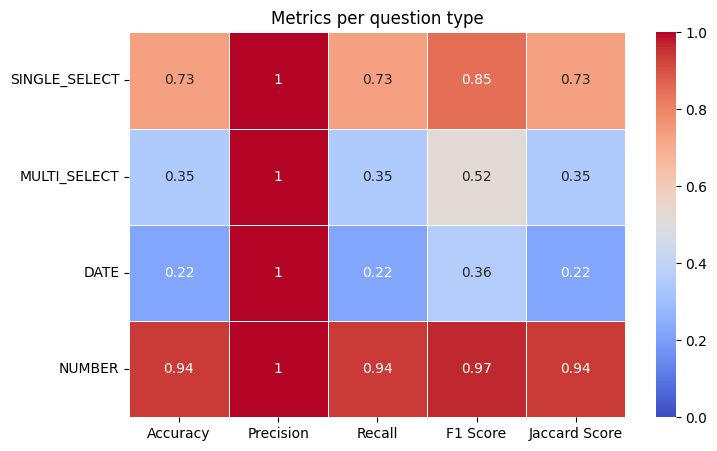

In [15]:
metrics, overall = predict_answers(df_simple, qa_pipeline1)

print()
print("Overall metrics:")
for key, value in overall.items():
    print(f"{key}: {value:.4f}")
print()

plot_metrics(metrics, overall)

### Predict answers for summarized DataFrame

No predictions found for MULTI_SELECT: Which of the following best describes your primary goal for using this app today?
[ERROR] DATE question processing failed: Unable to parse date from extracted time: end of tomorrow
[ERROR] DATE question processing failed: Unable to parse date from extracted time: next Thursday morning
No predictions found for SINGLE_SELECT: Data processing consent
[ERROR] DATE question processing failed: Unable to parse date from extracted time: next Thursday morning
[ERROR] DATE question processing failed: unsupported operand type(s) for -: 'datetime.datetime' and 'NoneType'
[ERROR] DATE question processing failed: Unable to parse date from extracted time: before next Thursday morning
Overall metrics:
Accuracy: 0.5667
Precision: 1.0000
Recall: 0.5667
F1 Score: 0.7234
Jaccard Score: 0.5667



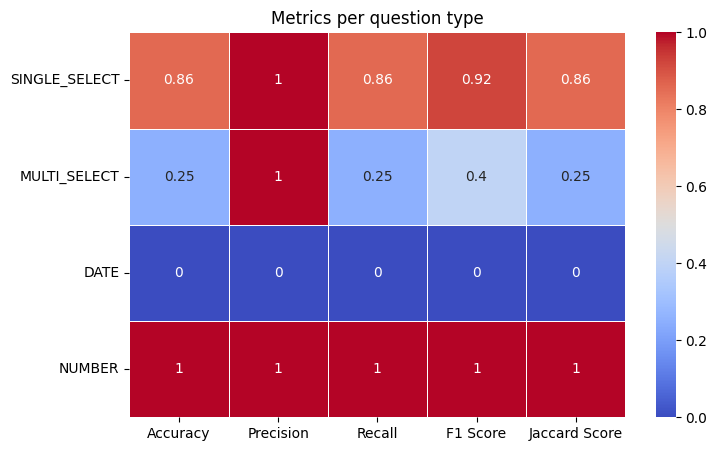

In [16]:
metrics, overall = predict_answers(df, qa_pipeline1)

print("Overall metrics:")
for key, value in overall.items():
    print(f"{key}: {value:.4f}")
print()

plot_metrics(metrics, overall)